

---


# INM 707 Coursework
# Advanced Task



> ## - Poorvika Singh Negi
> ## - Faisal Mungi




---




## Importing and installing dependencies

In [ ]:
import torch

import collections
import typing

import numpy as np



from torch import nn, optim
from torch.nn import functional as F



#import gym

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
!pip install Box2D
!pip install box2d-py
!pip install gym[all]
!pip install gym[Box_2D]




     |████████████████████████████████| 1.3 MB 4.2 MB/s 
     |████████████████████████████████| 448 kB 4.3 MB/s 
     |████████████████████████████████| 120 kB 4.1 MB/s 
     |████████████████████████████████| 206 kB 27.9 MB/s 
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-klk9z00l/mujoco-py_2467ff78b65a46fa93c2b850588627b2/setup.py'"'"'; __file__='"'"'/tmp/pip-install-klk9z00l/mujoco-py_2467ff78b65a46fa93c2b850588627b2/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-ff4

In [ ]:
!pip install gym[box2d]==0.17.*

In [ ]:
#!pip3 install box2d-py
#!pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

#_ = env.seed(42)

## Creating Experience Replay Buffer


In [ ]:

experience_tuple = ["state", "action", "reward", "next_state", "done"]


Experience = collections.namedtuple("Experience", experience_tuple)


class ExperienceReplayBuffer:
    """Fixed-size buffer to store Experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:
        
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        return len(self._buffer)
    
    @property
    def batch_size(self) -> int:
        """Number of experience samples per training batch."""
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        """Total number of experience samples stored in memory."""
        return self._buffer_size
    
    def append(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        self._buffer.append(experience)
    
    def sample(self) -> typing.List[Experience]:
        """Randomly sample a batch of experiences from memory."""
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences


## Defining agent

In [ ]:
class Agent:
    
    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError
        
    def learn(self, experiences: typing.List[Experience]) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        raise NotImplementedError

    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError


class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 double_dqn: bool = False,
                 seed: int = None) -> None:
        
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        
        # initialize agent hyperparameters
        _replay_buffer_kwargs = {
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = ExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self._double_dqn = double_dqn
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        self._synchronize_q_networks(self._target_q_network, self._online_q_network)        
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        
    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        """Create a neural network"""
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )
        return q_network
                 
    @staticmethod
    def _soft_update_q_network_parameters(q_network_1: nn.Module,
                                          q_network_2: nn.Module,
                                          alpha: float) -> None:
        """In-place, soft-update of q_network_1 parameters with parameters from q_network_2."""
        for p1, p2 in zip(q_network_1.parameters(), q_network_2.parameters()):
            p1.data.copy_(alpha * p2.data + (1 - alpha) * p1.data)
    
    @staticmethod
    def _synchronize_q_networks(q_network_1: nn.Module, q_network_2: nn.Module) -> None:
        """In place, synchronization of q_network_1 and q_network_2."""
        _ = q_network_1.load_state_dict(q_network_2.state_dict())
           
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
        
    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        action = (self._online_q_network(state)
                      .argmax()
                      .cpu()  # action_values might reside on the GPU!
                      .item())
        return action
    
    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state: np.array) -> int:
        
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))
            
        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    def learn(self, experiences: typing.List[Experience]) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        states, actions, rewards, next_states, dones = (torch.Tensor(vs).to(self._device) for vs in zip(*experiences))
        
        # need to add second dimension to some tensors
        actions = (actions.long()
                          .unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)
        
        if self._double_dqn:
            target_q_values = double_q_learning_update(next_states,
                                                       rewards,
                                                       dones,
                                                       self._gamma,
                                                       self._online_q_network,
                                                       self._target_q_network)
        else:
            target_q_values = q_learning_update(next_states,
                                                rewards,
                                                dones,
                                                self._gamma,
                                                self._target_q_network)

        online_q_values = (self._online_q_network(states)
                               .gather(dim=1, index=actions))
        
        # compute the mean squared loss
        loss = F.mse_loss(online_q_values, target_q_values)
        
        # updates the parameters of the online network
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        self._soft_update_q_network_parameters(self._target_q_network,
                                               self._online_q_network,
                                               self._alpha)
    
    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._memory) >= self._memory.batch_size
    
    def save(self, filepath: str) -> None:
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._memory.batch_size,
                "buffer_size": self._memory.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }
        torch.save(checkpoint, filepath)
        
    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        
        experience = Experience(state, action, reward, next_state, done)
        self._memory.append(experience)
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._memory.sample()
                self.learn(experiences)


Creating a function for training. We will train the agent in two different styles.

1.   Until Average Score threshold is met
2.   Until it runs the specified number of episodes



In [ ]:

def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state = env.reset()
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score

                
def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score


def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores


In [ ]:

def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    """Compute the Q-values by evaluating the actions given the current states and Q-network."""
    next_q_values = q_network(states).gather(dim=1, index=actions)        
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


def q_learning_update(states: torch.Tensor,
                      rewards: torch.Tensor,
                      dones: torch.Tensor,
                      gamma: float,
                      q_network: nn.Module) -> torch.Tensor:
    """Q-Learning update with explicitly decoupled action selection and evaluation steps."""
    actions = select_greedy_actions(states, q_network)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network)
    return q_values



Creating new learning update for Double-DQN. Using a second Q-network to evaluate the actions chosen by the first Q-network according to the Double-DQN algorithm

In [ ]:
def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    """Double Q-Learning uses Q-network 1 to select actions and Q-network 2 to evaluate the selected actions."""
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values

## Epsilon Decay function

The agent will explore the state space by random selection of an action with probability $\epsilon$, and with probability  $1-\epsilon$, the agent exploits its current knowledge by choosing the optimal action given that current state.
The agents acquires knowledge with the no of episodes passed so the epsilon value is decreased so that the agent aims to exploit more based of from the knowledge it has gained.

In [ ]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

## Optimizer

We have used Adam as our optimizer as it is known to be more stable and efficient for RL

In [ ]:
from torch import optim


_optimizer_kwargs = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

## Environment - LunarLander


Action Space 

There are four discrete actions available: 

0. Do nothing.
1. Fire the left orientation engine.
2. Fire main engine.
3. Fire the right orientation engine.

## Training using DQN

In [ ]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,  # True uses Double DQN; False uses DQN 
    "seed": None,
}
dqn_agent = DeepQAgent(**_agent_kwargs)

dqn_scores = train(dqn_agent,
                   env,
                   "dqn-checkpoint.pth",
                   number_episodes=1000,
                   target_score=200)

Episode 100	Average Score: -160.57
Episode 200	Average Score: -73.37
Episode 300	Average Score: -27.06
Episode 400	Average Score: 63.15
Episode 500	Average Score: 53.74
Episode 600	Average Score: 127.59

Environment solved in 651 episodes!	Average Score: 200.44


## Training using Double-DQN

In [ ]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,  # True uses Double DQN; False uses DQN 
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

double_dqn_scores = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint.pth",
                          number_episodes=1000,
                          target_score=200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Episode 100	Average Score: -143.95
Episode 200	Average Score: -55.13
Episode 300	Average Score: 17.31
Episode 400	Average Score: 117.91
Episode 500	Average Score: 141.16

Environment solved in 580 episodes!	Average Score: 200.40


## Comparing performance of DQN vs D-DQN

In [ ]:
#training DQN for 1000 episodes
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,
    "seed": None,
}
dqn_agent = DeepQAgent(**_agent_kwargs)

dqn_scores = train(dqn_agent,
                   env,
                   "dqn-checkpoint.pth",
                   number_episodes=1000,
                   target_score=float("inf"))

Episode 100	Average Score: -141.15
Episode 200	Average Score: -97.94
Episode 300	Average Score: -62.11
Episode 400	Average Score: -38.29
Episode 500	Average Score: 64.33
Episode 600	Average Score: 140.18
Episode 700	Average Score: 198.56
Episode 800	Average Score: 225.49
Episode 900	Average Score: 236.36
Episode 1000	Average Score: 254.44


In [ ]:
#training Double-DQN for 1000 episodes

_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

double_dqn_scores = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint.pth",
                          number_episodes=1000,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

Episode 100	Average Score: -142.29
Episode 200	Average Score: -67.60
Episode 300	Average Score: -42.77
Episode 400	Average Score: -2.24
Episode 500	Average Score: 121.02
Episode 600	Average Score: 185.72
Episode 700	Average Score: 212.60
Episode 800	Average Score: 182.25
Episode 900	Average Score: 220.24
Episode 1000	Average Score: 238.08


## Visualizing Results

In [ ]:
dqn_scores = pd.Series(dqn_scores, name="scores")
double_dqn_scores = pd.Series(double_dqn_scores, name="scores")

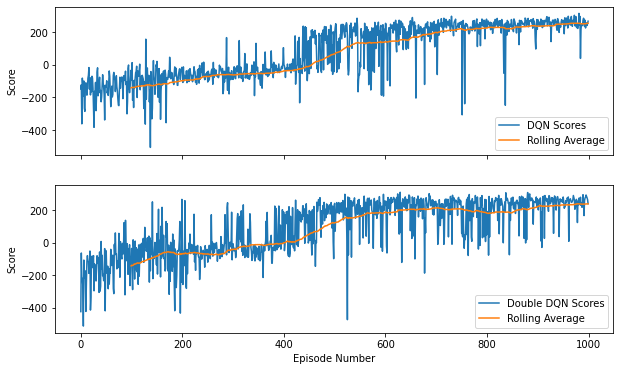

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = dqn_scores.plot(ax=axes[0], label="DQN Scores")
_ = (dqn_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[0]))
_ = axes[0].legend()
_ = axes[0].set_ylabel("Score")

_ = double_dqn_scores.plot(ax=axes[1], label="Double DQN Scores")
_ = (double_dqn_scores.rolling(window=100)
                      .mean()
                      .rename("Rolling Average")
                      .plot(ax=axes[1]))
_ = axes[1].legend()
_ = axes[1].set_ylabel("Score")
_ = axes[1].set_xlabel("Episode Number")


## Effect of Parameters 

### Alpha (lr)

Comparing effect of different learning rates (initial alpha = 1e-3)
alpha = 0.1, 1e-5


---



In [ ]:
# training dqn agent for 1000 episodes

# agent 4,5 are using dqn 
print("\n\nDQN with lr = 0.1\n")
_agent_kwargs4 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 0.1,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,
    "seed": None,
}
agent4 = DeepQAgent(**_agent_kwargs4)

scores4 = train(agent4,
                          env,
                          "double-dqn4-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

print("\n\nDQN with lr = 1e-5\n")
_agent_kwargs5 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-5,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,
    "seed": None,
}
agent5 = DeepQAgent(**_agent_kwargs5)

scores5 = train(agent5,
                          env,
                          "double-dqn5-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

# agent 6,7 are using double dqn 
print("\n\nDouble-DQN with lr = 0.1\n")
_agent_kwargs6 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 0.1,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,
    "seed": None,
}
agent6 = DeepQAgent(**_agent_kwargs6)

scores6 = train(agent6,
                          env,
                          "double-dqn6-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

print("\n\nDouble-DQN with lr = 1e-5\n")
_agent_kwargs7 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-5,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,
    "seed": None,
}
agent7 = DeepQAgent(**_agent_kwargs7)

scores7 = train(agent7,
                          env,
                          "double-dqn7-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )




DQN with lr = 0.1

Episode 100	Average Score: -133.88
Episode 200	Average Score: -41.92
Episode 300	Average Score: -17.74


DQN with lr = 1e-5

Episode 100	Average Score: -147.95
Episode 200	Average Score: -162.08
Episode 300	Average Score: -192.30


Double-DQN with lr = 0.1

Episode 100	Average Score: -141.27
Episode 200	Average Score: 31.23
Episode 300	Average Score: 110.79


Double-DQN with lr = 1e-5

Episode 100	Average Score: -172.64
Episode 200	Average Score: -232.57
Episode 300	Average Score: -255.14


Plotting results for different lr



---



In [ ]:
scores4 = pd.Series(scores4, name="DQN lr=0.1")
scores5 = pd.Series(scores5, name="DQN lr=1e-5")
scores6 = pd.Series(scores6, name="D-DQN lr=0.1")
scores7 = pd.Series(scores7, name="D-DQN lr=1e-5")


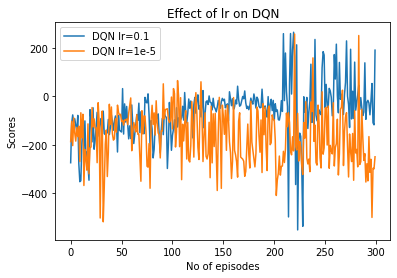

In [ ]:
scores4.plot.line()
scores5.plot.line()
plt.xlabel('No of episodes')
plt.ylabel('Scores')
plt.title('Effect of lr on DQN')
plt.legend()


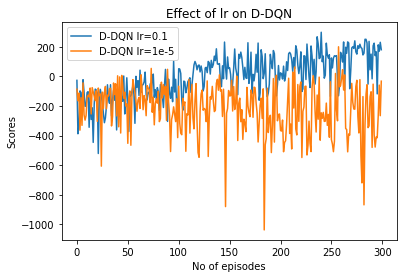

In [ ]:

scores6.plot.line()
scores7.plot.line()
plt.xlabel('No of episodes')
plt.ylabel('Scores')
plt.title('Effect of lr on D-DQN')
plt.legend()

In [ ]:
# training dqn agent for 1000 episodes

# agent 4,5 are using dqn 
print("\n\nDQN with gamma = 0.999\n")
_agent_kwargs4 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.999,
    "update_frequency": 4,
    "double_dqn": False,
    "seed": None,
}
agent4 = DeepQAgent(**_agent_kwargs4)

scores4 = train(agent4,
                          env,
                          "double-dqn4-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

print("\n\nDQN with gamma = 0.8\n")
_agent_kwargs5 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.8,
    "update_frequency": 4,
    "double_dqn": False,
    "seed": None,
}
agent5 = DeepQAgent(**_agent_kwargs5)

scores5 = train(agent5,
                          env,
                          "double-dqn5-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

# agent 6,7 are using double dqn 
print("\n\nDouble-DQN with gamma = 0.99\n")
_agent_kwargs6 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.999,
    "update_frequency": 4,
    "double_dqn": True,
    "seed": None,
}
agent6 = DeepQAgent(**_agent_kwargs6)

scores6 = train(agent6,
                          env,
                          "double-dqn6-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )

print("\n\nDouble-DQN with gamma = 0.8\n")
_agent_kwargs7 = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n, 
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.8,
    "update_frequency": 4,
    "double_dqn": True,
    "seed": None,
}
agent7 = DeepQAgent(**_agent_kwargs7)

scores7 = train(agent7,
                          env,
                          "double-dqn7-checkpoint.pth",
                          number_episodes=300,
                          target_score=float("inf"), # hack to insure that training never terminates early
                         )




DQN with gamma = 0.999

Episode 100	Average Score: -166.38
Episode 200	Average Score: -140.46
Episode 300	Average Score: -47.58


DQN with gamma = 0.8

Episode 100	Average Score: -159.95
Episode 200	Average Score: -122.62
Episode 300	Average Score: -42.31


Double-DQN with gamma = 0.99

Episode 100	Average Score: -154.10
Episode 200	Average Score: -92.25
Episode 300	Average Score: -68.37


Double-DQN with gamma = 0.8

Episode 100	Average Score: -161.04
Episode 200	Average Score: -76.96
Episode 300	Average Score: -69.45


### Gamma

Comparing effect of different gamma (initial gamma = 0.99)

gamma = 0.999, 0.8


---



In [ ]:
scores4 = pd.Series(scores4, name="DQN gamma=0.999")
scores5 = pd.Series(scores5, name="DQN gamma=0.8")
scores6 = pd.Series(scores6, name="D-DQN gamma=0.999")
scores7 = pd.Series(scores7, name="D-DQN gamma=0.8")


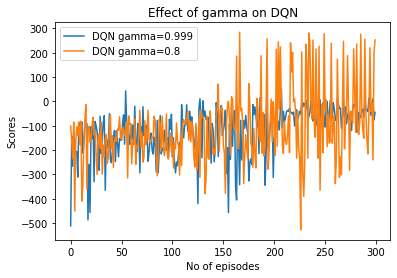

In [ ]:
scores4.plot.line()
scores5.plot.line()
plt.xlabel('No of episodes')
plt.ylabel('Scores')
plt.title('Effect of gamma on DQN')
plt.legend()


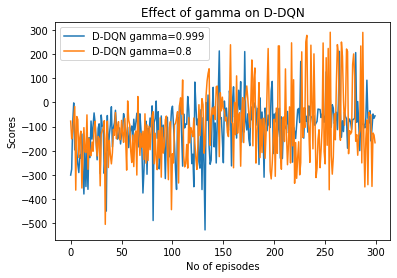

In [ ]:

scores6.plot.line()
scores7.plot.line()
plt.xlabel('No of episodes')
plt.ylabel('Scores')
plt.title('Effect of gamma on D-DQN')
plt.legend()